**LABORATORIO 3**

*   Dataset:https://drive.google.com/drive/folders/14MZNuZg5xmbKtR3L9Wq_Tdwu9eyNliL6?usp=sharing
*   repositorio github:https://github.com/R1mber/sis421/tree/master/Laboratorios



In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#copiamos las imagenes de /drive a /img

In [ ]:
#cp -av "/content/drive/MyDrive/ia 2/dataset_flores" "/content/img"

'/content/drive/MyDrive/ia 2/dataset_flores' -> '/content/img'


In [ ]:
#cp -av /content/drive/MyDrive/inteligencia_artificial/ia2/dataset_flores /content/img

In [ ]:
path = '/content/img/'
directorios = os.listdir(path)
directorios

['tagetes', 'Hibisco', 'FlorRita', 'claveles', 'Girasoles', 'lirio']

In [ ]:
labels_def = {'Hibisco':0, 'Girasoles':1, 'tagetes':2, 'FlorRita':3, 'claveles':4,'lirio':5}

In [ ]:
def loadImages(path, directorio):
    labels_ = []
    images_ = []
    for d in directorio:
        imagenes = os.listdir(path + d)
        for i in imagenes:
            imgPath2 = path + d + '/' + i
            images_.append(imgPath2)
            labels_.append(labels_def[d])
    return images_, labels_


In [ ]:
imgs , labels = loadImages(path,directorios)

In [ ]:
def getText(label):
    for key in labels_def:
      if labels_def[key] == label:
        return key

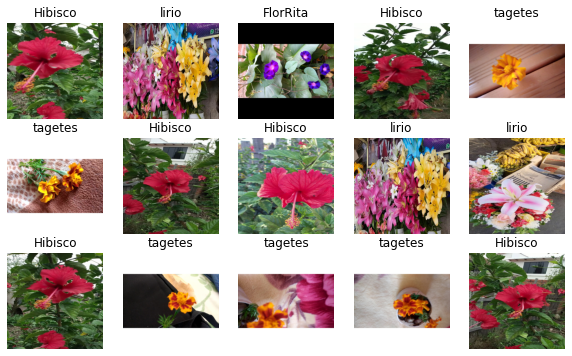

In [ ]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(getText(labels[ix]))
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.05, stratify=labels)

len(train_imgs), len(test_imgs)

(6434, 339)

In [ ]:
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = X #torch.from_numpy(X).float().cuda()
        self.Y = Y #torch.from_numpy(Y).long().cuda()
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        img1 = Image.open(self.X[ix])
        new_img = img1.resize((100,100))
        #normalizamos la imagen 
        npImage = np.array(new_img)
        #return self.X[ix], self.Y[ix]
        #img = self.trans(image=img)["image"]
        return torch.from_numpy(npImage / 255.).float().permute(2,0,1), torch.tensor(self.Y[ix])

In [ ]:
dataset = {
    'train': Dataset(train_imgs, train_labels), 
    'test': Dataset(test_imgs, test_labels)
}
len(dataset['train']), len(dataset['test']),

(6434, 339)

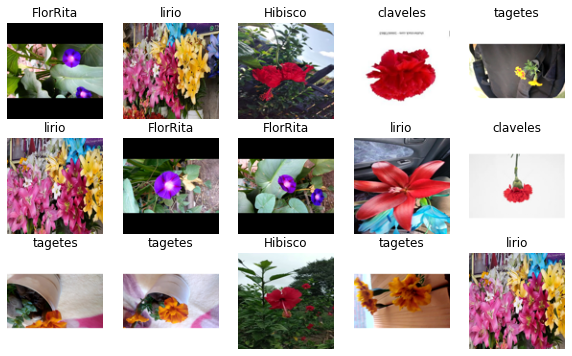

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['test'])-1)
    img, lab = dataset['test'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(getText(lab))
    #ax.set_title(classes[lab])
plt.show()

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=65, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=50, shuffle=False)
}

x_train, y_train = next(iter(dataloader['train']))

In [ ]:
x_train.shape ,x_train[0].shape

(torch.Size([65, 3, 100, 100]), torch.Size([3, 100, 100]))

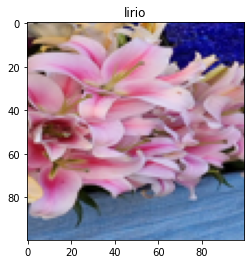

In [ ]:
rand = random.randint(0, len(x_train))
img_perm=x_train[rand].permute(1, 2,0)
plt.imshow(img_perm)
plt.title(getText(y_train[rand]))
plt.show()


In [ ]:
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 5, padding = 2, stride = 2)

output = conv(x_train)

# dimensiones: (N, #filtros, H', W')
output.shape

torch.Size([65, 10, 50, 50])

In [ ]:
x_train[0].shape

torch.Size([3, 100, 100])

In [ ]:
pool = torch.nn.MaxPool2d(3, padding=2, stride=2)

img_tensor = x_train[0].unsqueeze(0)
#print(x_train[0].shape)

m = torch.nn.MaxPool2d(6, stride=2, padding=2)
input = torch.randn(20, 3, 100, 100)
output = m(img_tensor)
#output = pool(img_tensor,)
output.shape

torch.Size([1, 3, 50, 50])

In [ ]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )
class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=6):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*25*25, n_outputs)

  def forward(self, x):
    print("Dimensiones:")
    print("Entrada: ", x.shape)
    x = self.conv1(x)
    print("conv1: ", x.shape)
    x = self.conv2(x)
    print("conv2: ", x.shape)
    x = x.view(x.shape[0], -1)
    print("pre fc: ", x.shape)
    x = self.fc(x)
    print("Salida: ", x.shape)
    return x

In [ ]:
model = CNN()

output = model(torch.randn(64, 3, 100, 100))

Dimensiones:
Entrada:  torch.Size([64, 3, 100, 100])
conv1:  torch.Size([64, 64, 50, 50])
conv2:  torch.Size([64, 128, 25, 25])
pre fc:  torch.Size([64, 80000])
Salida:  torch.Size([64, 6])


In [ ]:
from tqdm import tqdm
import numpy as np
device = "cuda"
def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = CNN()
fit(model, dataloader)

loss 1.79516 acc 0.06154:   1%|          | 1/99 [00:08<13:29,  8.26s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 3.62587 acc 0.09231:   2%|▏         | 2/99 [00:16<13:03,  8.08s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 3.45154 acc 0.17949:   3%|▎         | 3/99 [00:23<12:37,  7.90s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 3.09028 acc 0.25000:   4%|▍         | 4/99 [00:30<11:36,  7.34s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 2.79546 acc 0.30462:   5%|▌         | 5/99 [00:38<11:45,  7.51s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 2.52823 acc 0.35897:   6%|▌         | 6/99 [00:44<11:05,  7.16s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 2.33273 acc 0.38901:   7%|▋         | 7/99 [00:52<11:18,  7.38s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 2.17956 acc 0.42692:   8%|▊         | 8/99 [01:00<11:29,  7.58s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 2.03953 acc 0.46667:   9%|▉         | 9/99 [01:09<11:52,  7.92s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.91656 acc 0.49692:  10%|█         | 10/99 [01:17<11:54,  8.03s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.80879 acc 0.52448:  11%|█         | 11/99 [01:26<12:08,  8.28s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.71114 acc 0.55256:  12%|█▏        | 12/99 [01:34<12:11,  8.40s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.61796 acc 0.57633:  13%|█▎        | 13/99 [01:41<11:16,  7.87s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.54264 acc 0.59780:  14%|█▍        | 14/99 [01:48<10:38,  7.51s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.47332 acc 0.61641:  15%|█▌        | 15/99 [01:55<10:34,  7.55s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.40863 acc 0.63269:  16%|█▌        | 16/99 [02:02<10:09,  7.34s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.34098 acc 0.64977:  17%|█▋        | 17/99 [02:09<09:50,  7.20s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.28230 acc 0.66325:  18%|█▊        | 18/99 [02:16<09:41,  7.18s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.22951 acc 0.67854:  19%|█▉        | 19/99 [02:23<09:34,  7.18s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.17513 acc 0.69462:  20%|██        | 20/99 [02:32<10:01,  7.61s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.13627 acc 0.70549:  21%|██        | 21/99 [02:38<09:15,  7.12s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.09428 acc 0.71538:  22%|██▏       | 22/99 [02:45<08:57,  6.98s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.05298 acc 0.72642:  23%|██▎       | 23/99 [02:54<09:35,  7.58s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 1.01491 acc 0.73654:  24%|██▍       | 24/99 [03:01<09:12,  7.37s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.97807 acc 0.74708:  25%|██▌       | 25/99 [03:08<09:11,  7.45s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.94518 acc 0.75562:  26%|██▋       | 26/99 [03:16<09:13,  7.58s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.91349 acc 0.76353:  27%|██▋       | 27/99 [03:24<09:11,  7.65s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.88725 acc 0.77088:  28%|██▊       | 28/99 [03:32<09:02,  7.64s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.85941 acc 0.77772:  29%|██▉       | 29/99 [03:38<08:31,  7.31s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.83349 acc 0.78410:  30%|███       | 30/99 [03:45<08:23,  7.30s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.81289 acc 0.78958:  31%|███▏      | 31/99 [03:53<08:31,  7.52s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.79749 acc 0.79279:  32%|███▏      | 32/99 [04:01<08:31,  7.63s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.77915 acc 0.79767:  33%|███▎      | 33/99 [04:09<08:33,  7.78s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.75820 acc 0.80362:  34%|███▍      | 34/99 [04:18<08:35,  7.94s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.74168 acc 0.80747:  35%|███▌      | 35/99 [04:26<08:30,  7.98s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.72367 acc 0.81197:  36%|███▋      | 36/99 [04:33<08:09,  7.77s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.70992 acc 0.81622:  37%|███▋      | 37/99 [04:41<08:03,  7.79s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.69365 acc 0.81943:  38%|███▊      | 38/99 [04:48<07:39,  7.53s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.67775 acc 0.82288:  39%|███▉      | 39/99 [04:56<07:45,  7.76s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.66317 acc 0.82654:  40%|████      | 40/99 [05:04<07:38,  7.77s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.65390 acc 0.83002:  41%|████▏     | 41/99 [05:12<07:35,  7.85s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.64242 acc 0.83150:  42%|████▏     | 42/99 [05:20<07:37,  8.03s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.62859 acc 0.83470:  43%|████▎     | 43/99 [05:27<07:09,  7.67s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.61701 acc 0.83776:  44%|████▍     | 44/99 [05:35<07:07,  7.76s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.60564 acc 0.84068:  45%|████▌     | 45/99 [05:43<06:55,  7.69s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.59444 acc 0.84381:  46%|████▋     | 46/99 [05:52<07:18,  8.27s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.58446 acc 0.84615:  47%|████▋     | 47/99 [06:01<07:10,  8.28s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.57325 acc 0.84904:  48%|████▊     | 48/99 [06:09<06:59,  8.22s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.56221 acc 0.85212:  49%|████▉     | 49/99 [06:17<06:49,  8.20s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.55431 acc 0.85477:  51%|█████     | 50/99 [06:25<06:43,  8.24s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.54874 acc 0.85671:  52%|█████▏    | 51/99 [06:34<06:40,  8.34s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.53851 acc 0.85917:  53%|█████▎    | 52/99 [06:41<06:20,  8.09s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.53058 acc 0.86125:  54%|█████▎    | 53/99 [06:49<06:11,  8.07s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.52268 acc 0.86268:  55%|█████▍    | 54/99 [06:59<06:18,  8.40s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.51383 acc 0.86517:  56%|█████▌    | 55/99 [07:07<06:15,  8.53s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.50682 acc 0.86731:  57%|█████▋    | 56/99 [07:15<05:57,  8.32s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.49990 acc 0.86883:  58%|█████▊    | 57/99 [07:23<05:44,  8.20s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.49545 acc 0.87029:  59%|█████▊    | 58/99 [07:31<05:34,  8.15s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.48740 acc 0.87249:  60%|█████▉    | 59/99 [07:39<05:25,  8.14s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.48036 acc 0.87436:  61%|██████    | 60/99 [07:45<04:51,  7.47s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.47280 acc 0.87642:  62%|██████▏   | 61/99 [07:53<04:48,  7.60s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.46549 acc 0.87841:  63%|██████▎   | 62/99 [08:00<04:31,  7.33s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.45826 acc 0.88034:  64%|██████▎   | 63/99 [08:07<04:25,  7.38s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.45411 acc 0.88149:  65%|██████▍   | 64/99 [08:16<04:31,  7.76s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.44792 acc 0.88284:  66%|██████▌   | 65/99 [08:25<04:34,  8.06s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.44201 acc 0.88415:  67%|██████▋   | 66/99 [08:34<04:34,  8.31s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.43568 acc 0.88588:  68%|██████▊   | 67/99 [08:41<04:17,  8.05s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.42969 acc 0.88756:  69%|██████▊   | 68/99 [08:46<03:43,  7.22s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.42437 acc 0.88896:  70%|██████▉   | 69/99 [08:56<03:56,  7.89s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.42157 acc 0.88967:  71%|███████   | 70/99 [09:04<03:51,  7.97s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.41612 acc 0.89101:  72%|███████▏  | 71/99 [09:12<03:40,  7.87s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.41057 acc 0.89252:  73%|███████▎  | 72/99 [09:18<03:22,  7.50s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.40527 acc 0.89378:  74%|███████▎  | 73/99 [09:24<03:05,  7.12s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.40159 acc 0.89459:  75%|███████▍  | 74/99 [09:32<03:02,  7.31s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.39648 acc 0.89600:  76%|███████▌  | 75/99 [09:40<02:56,  7.36s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.39157 acc 0.89737:  77%|███████▋  | 76/99 [09:48<02:58,  7.76s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.38751 acc 0.89830:  78%|███████▊  | 77/99 [09:55<02:46,  7.55s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.38263 acc 0.89961:  79%|███████▉  | 78/99 [10:03<02:38,  7.56s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.37883 acc 0.90049:  80%|███████▉  | 79/99 [10:10<02:29,  7.47s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.37557 acc 0.90154:  81%|████████  | 80/99 [10:18<02:26,  7.71s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.37109 acc 0.90275:  82%|████████▏ | 81/99 [10:26<02:19,  7.73s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.36835 acc 0.90356:  83%|████████▎ | 82/99 [10:33<02:06,  7.42s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.36415 acc 0.90473:  84%|████████▍ | 83/99 [10:41<02:03,  7.69s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.35993 acc 0.90586:  85%|████████▍ | 84/99 [10:50<01:58,  7.88s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.35627 acc 0.90661:  86%|████████▌ | 85/99 [10:57<01:48,  7.77s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.35265 acc 0.90751:  87%|████████▋ | 86/99 [11:07<01:47,  8.27s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.34863 acc 0.90858:  88%|████████▊ | 87/99 [11:15<01:39,  8.33s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.34494 acc 0.90944:  89%|████████▉ | 88/99 [11:24<01:33,  8.52s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.34125 acc 0.91046:  90%|████████▉ | 89/99 [11:31<01:21,  8.17s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.33788 acc 0.91128:  91%|█████████ | 90/99 [11:39<01:11,  7.99s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.33476 acc 0.91209:  92%|█████████▏| 91/99 [11:47<01:05,  8.14s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.33130 acc 0.91304:  93%|█████████▎| 92/99 [11:55<00:54,  7.84s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.32800 acc 0.91398:  94%|█████████▍| 93/99 [12:01<00:43,  7.29s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.32466 acc 0.91489:  95%|█████████▍| 94/99 [12:09<00:37,  7.60s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.32170 acc 0.91563:  96%|█████████▌| 95/99 [12:16<00:29,  7.37s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.31893 acc 0.91619:  97%|█████████▋| 96/99 [12:24<00:22,  7.51s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.31652 acc 0.91689:  98%|█████████▊| 97/99 [12:33<00:15,  7.97s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.31379 acc 0.91758:  99%|█████████▉| 98/99 [12:38<00:07,  7.25s/it]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.31127 acc 0.91810: 100%|██████████| 99/99 [12:46<00:00,  7.74s/it]


Dimensiones:
Entrada:  torch.Size([64, 3, 100, 100])
conv1:  torch.Size([64, 64, 50, 50])
conv2:  torch.Size([64, 128, 25, 25])
pre fc:  torch.Size([64, 80000])
Salida:  torch.Size([64, 6])


val_loss 0.05859 val_acc 0.96000:  14%|█▍        | 1/7 [00:07<00:43,  7.23s/it]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.06863 val_acc 0.97000:  29%|██▊       | 2/7 [00:15<00:38,  7.68s/it]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.05785 val_acc 0.98000:  43%|████▎     | 3/7 [00:23<00:32,  8.06s/it]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.06238 val_acc 0.97500:  57%|█████▋    | 4/7 [00:31<00:24,  8.04s/it]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.08659 val_acc 0.96800:  71%|███████▏  | 5/7 [00:39<00:16,  8.07s/it]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.07523 val_acc 0.97333:  86%|████████▌ | 6/7 [00:48<00:08,  8.35s/it]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.06513 val_acc 0.97714: 100%|██████████| 7/7 [00:55<00:00,  7.99s/it]


Dimensiones:
Entrada:  torch.Size([39, 3, 100, 100])
conv1:  torch.Size([39, 64, 50, 50])
conv2:  torch.Size([39, 128, 25, 25])
pre fc:  torch.Size([39, 80000])
Salida:  torch.Size([39, 6])
Epoch 1/5 loss 0.31127 val_loss 0.06513 acc 0.91810 val_acc 0.97714


loss 0.01959 acc 1.00000:   1%|          | 1/99 [00:00<01:04,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01123 acc 1.00000:   2%|▏         | 2/99 [00:01<01:04,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02018 acc 0.99487:   3%|▎         | 3/99 [00:01<01:02,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02664 acc 0.98846:   4%|▍         | 4/99 [00:02<01:01,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02261 acc 0.99077:   5%|▌         | 5/99 [00:03<01:01,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02358 acc 0.98974:   6%|▌         | 6/99 [00:03<01:00,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02082 acc 0.99121:   7%|▋         | 7/99 [00:04<00:58,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02129 acc 0.99038:   8%|▊         | 8/99 [00:05<00:58,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02040 acc 0.99145:   9%|▉         | 9/99 [00:05<00:57,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01945 acc 0.99231:  10%|█         | 10/99 [00:06<00:56,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01799 acc 0.99301:  11%|█         | 11/99 [00:07<00:57,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02149 acc 0.99231:  12%|█▏        | 12/99 [00:07<00:57,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02042 acc 0.99290:  13%|█▎        | 13/99 [00:08<00:56,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02175 acc 0.99231:  14%|█▍        | 14/99 [00:09<00:56,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02128 acc 0.99282:  15%|█▌        | 15/99 [00:09<00:56,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02053 acc 0.99327:  16%|█▌        | 16/99 [00:10<00:54,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01947 acc 0.99367:  17%|█▋        | 17/99 [00:11<00:54,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02347 acc 0.99316:  18%|█▊        | 18/99 [00:11<00:53,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02256 acc 0.99352:  19%|█▉        | 19/99 [00:12<00:52,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02166 acc 0.99385:  20%|██        | 20/99 [00:13<00:52,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02158 acc 0.99414:  21%|██        | 21/99 [00:13<00:51,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02077 acc 0.99441:  22%|██▏       | 22/99 [00:14<00:50,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02026 acc 0.99465:  23%|██▎       | 23/99 [00:15<00:50,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01986 acc 0.99487:  24%|██▍       | 24/99 [00:15<00:50,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01940 acc 0.99508:  25%|██▌       | 25/99 [00:16<00:48,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01924 acc 0.99527:  26%|██▋       | 26/99 [00:17<00:47,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01880 acc 0.99544:  27%|██▋       | 27/99 [00:17<00:47,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01848 acc 0.99560:  28%|██▊       | 28/99 [00:18<00:46,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01907 acc 0.99523:  29%|██▉       | 29/99 [00:19<00:46,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01854 acc 0.99538:  30%|███       | 30/99 [00:19<00:45,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01827 acc 0.99553:  31%|███▏      | 31/99 [00:20<00:45,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01816 acc 0.99567:  32%|███▏      | 32/99 [00:21<00:44,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01790 acc 0.99580:  33%|███▎      | 33/99 [00:21<00:43,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01764 acc 0.99593:  34%|███▍      | 34/99 [00:22<00:42,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01734 acc 0.99604:  35%|███▌      | 35/99 [00:22<00:41,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01851 acc 0.99573:  36%|███▋      | 36/99 [00:23<00:41,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01808 acc 0.99584:  37%|███▋      | 37/99 [00:24<00:40,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01786 acc 0.99595:  38%|███▊      | 38/99 [00:24<00:39,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01768 acc 0.99606:  39%|███▉      | 39/99 [00:25<00:38,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01769 acc 0.99615:  40%|████      | 40/99 [00:26<00:38,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01747 acc 0.99625:  41%|████▏     | 41/99 [00:26<00:37,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01738 acc 0.99597:  42%|████▏     | 42/99 [00:27<00:36,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02013 acc 0.99571:  43%|████▎     | 43/99 [00:28<00:35,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02007 acc 0.99545:  44%|████▍     | 44/99 [00:28<00:35,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01991 acc 0.99556:  45%|████▌     | 45/99 [00:29<00:34,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01972 acc 0.99565:  46%|████▋     | 46/99 [00:30<00:34,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01956 acc 0.99574:  47%|████▋     | 47/99 [00:30<00:33,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01919 acc 0.99583:  48%|████▊     | 48/99 [00:31<00:33,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01893 acc 0.99592:  49%|████▉     | 49/99 [00:32<00:32,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01883 acc 0.99600:  51%|█████     | 50/99 [00:32<00:31,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01857 acc 0.99608:  52%|█████▏    | 51/99 [00:33<00:31,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01939 acc 0.99586:  53%|█████▎    | 52/99 [00:34<00:30,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01997 acc 0.99565:  54%|█████▎    | 53/99 [00:34<00:29,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01973 acc 0.99573:  55%|█████▍    | 54/99 [00:35<00:28,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01940 acc 0.99580:  56%|█████▌    | 55/99 [00:35<00:28,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02054 acc 0.99560:  57%|█████▋    | 56/99 [00:36<00:27,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02100 acc 0.99541:  58%|█████▊    | 57/99 [00:37<00:26,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02074 acc 0.99549:  59%|█████▊    | 58/99 [00:37<00:26,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02053 acc 0.99557:  60%|█████▉    | 59/99 [00:38<00:25,  1.58it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02047 acc 0.99564:  61%|██████    | 60/99 [00:39<00:24,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02031 acc 0.99571:  62%|██████▏   | 61/99 [00:39<00:24,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02009 acc 0.99578:  63%|██████▎   | 62/99 [00:40<00:24,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01985 acc 0.99585:  64%|██████▎   | 63/99 [00:41<00:24,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02042 acc 0.99567:  65%|██████▍   | 64/99 [00:41<00:23,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02039 acc 0.99550:  66%|██████▌   | 65/99 [00:42<00:22,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02138 acc 0.99534:  67%|██████▋   | 66/99 [00:43<00:22,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02111 acc 0.99541:  68%|██████▊   | 67/99 [00:43<00:21,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02101 acc 0.99525:  69%|██████▊   | 68/99 [00:44<00:21,  1.47it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02082 acc 0.99532:  70%|██████▉   | 69/99 [00:45<00:20,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02178 acc 0.99495:  71%|███████   | 70/99 [00:45<00:18,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02212 acc 0.99480:  72%|███████▏  | 71/99 [00:46<00:18,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02231 acc 0.99466:  73%|███████▎  | 72/99 [00:47<00:17,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02205 acc 0.99473:  74%|███████▎  | 73/99 [00:47<00:17,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02184 acc 0.99480:  75%|███████▍  | 74/99 [00:48<00:15,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02156 acc 0.99487:  76%|███████▌  | 75/99 [00:49<00:15,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02133 acc 0.99494:  77%|███████▋  | 76/99 [00:49<00:15,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02258 acc 0.99461:  78%|███████▊  | 77/99 [00:50<00:14,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02405 acc 0.99428:  79%|███████▉  | 78/99 [00:50<00:13,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02378 acc 0.99435:  80%|███████▉  | 79/99 [00:51<00:12,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02369 acc 0.99442:  81%|████████  | 80/99 [00:52<00:12,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02344 acc 0.99449:  82%|████████▏ | 81/99 [00:52<00:11,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02319 acc 0.99456:  83%|████████▎ | 82/99 [00:53<00:11,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02408 acc 0.99444:  84%|████████▍ | 83/99 [00:54<00:10,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02396 acc 0.99432:  85%|████████▍ | 84/99 [00:54<00:09,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02374 acc 0.99439:  86%|████████▌ | 85/99 [00:55<00:09,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02353 acc 0.99445:  87%|████████▋ | 86/99 [00:56<00:08,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02339 acc 0.99452:  88%|████████▊ | 87/99 [00:56<00:08,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02345 acc 0.99441:  89%|████████▉ | 88/99 [00:57<00:07,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02365 acc 0.99430:  90%|████████▉ | 89/99 [00:58<00:06,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02356 acc 0.99436:  91%|█████████ | 90/99 [00:59<00:06,  1.47it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02347 acc 0.99442:  92%|█████████▏| 91/99 [00:59<00:05,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02393 acc 0.99431:  93%|█████████▎| 92/99 [01:00<00:04,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02403 acc 0.99421:  94%|█████████▍| 93/99 [01:01<00:04,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02399 acc 0.99411:  95%|█████████▍| 94/99 [01:01<00:03,  1.46it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02391 acc 0.99417:  96%|█████████▌| 95/99 [01:02<00:02,  1.46it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02368 acc 0.99423:  97%|█████████▋| 96/99 [01:03<00:02,  1.47it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02348 acc 0.99429:  98%|█████████▊| 97/99 [01:03<00:01,  1.45it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02332 acc 0.99435:  99%|█████████▉| 98/99 [01:04<00:00,  1.44it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02358 acc 0.99409: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


Dimensiones:
Entrada:  torch.Size([64, 3, 100, 100])
conv1:  torch.Size([64, 64, 50, 50])
conv2:  torch.Size([64, 128, 25, 25])
pre fc:  torch.Size([64, 80000])
Salida:  torch.Size([64, 6])


val_loss 0.03697 val_acc 0.98000:  14%|█▍        | 1/7 [00:00<00:02,  2.06it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.08865 val_acc 0.98000:  29%|██▊       | 2/7 [00:00<00:02,  2.01it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.07837 val_acc 0.98000:  43%|████▎     | 3/7 [00:01<00:01,  2.03it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.06890 val_acc 0.98000:  57%|█████▋    | 4/7 [00:01<00:01,  2.04it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.08876 val_acc 0.98000:  71%|███████▏  | 5/7 [00:02<00:00,  2.06it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.08595 val_acc 0.98000:  86%|████████▌ | 6/7 [00:02<00:00,  2.12it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.07888 val_acc 0.98286: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Dimensiones:
Entrada:  torch.Size([39, 3, 100, 100])
conv1:  torch.Size([39, 64, 50, 50])
conv2:  torch.Size([39, 128, 25, 25])
pre fc:  torch.Size([39, 80000])
Salida:  torch.Size([39, 6])
Epoch 2/5 loss 0.02358 val_loss 0.07888 acc 0.99409 val_acc 0.98286


loss 0.01280 acc 1.00000:   1%|          | 1/99 [00:00<01:07,  1.45it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01116 acc 1.00000:   2%|▏         | 2/99 [00:01<01:05,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01275 acc 1.00000:   3%|▎         | 3/99 [00:02<01:03,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.03300 acc 0.99231:   4%|▍         | 4/99 [00:02<01:01,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02888 acc 0.99385:   5%|▌         | 5/99 [00:03<01:01,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02673 acc 0.99487:   6%|▌         | 6/99 [00:03<01:00,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02511 acc 0.99341:   7%|▋         | 7/99 [00:04<01:00,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02352 acc 0.99423:   8%|▊         | 8/99 [00:05<00:59,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02128 acc 0.99487:   9%|▉         | 9/99 [00:05<00:58,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02686 acc 0.99385:  10%|█         | 10/99 [00:06<00:57,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02456 acc 0.99441:  11%|█         | 11/99 [00:07<00:57,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02272 acc 0.99487:  12%|█▏        | 12/99 [00:07<00:56,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02465 acc 0.99408:  13%|█▎        | 13/99 [00:08<00:56,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02474 acc 0.99341:  14%|█▍        | 14/99 [00:09<00:54,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02358 acc 0.99385:  15%|█▌        | 15/99 [00:09<00:53,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02295 acc 0.99423:  16%|█▌        | 16/99 [00:10<00:53,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02217 acc 0.99457:  17%|█▋        | 17/99 [00:11<00:52,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02132 acc 0.99487:  18%|█▊        | 18/99 [00:11<00:51,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02051 acc 0.99514:  19%|█▉        | 19/99 [00:12<00:51,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02041 acc 0.99462:  20%|██        | 20/99 [00:12<00:51,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02050 acc 0.99414:  21%|██        | 21/99 [00:13<00:50,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01977 acc 0.99441:  22%|██▏       | 22/99 [00:14<00:49,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01917 acc 0.99465:  23%|██▎       | 23/99 [00:14<00:49,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01894 acc 0.99487:  24%|██▍       | 24/99 [00:15<00:48,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01858 acc 0.99508:  25%|██▌       | 25/99 [00:16<00:48,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01827 acc 0.99527:  26%|██▋       | 26/99 [00:16<00:48,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01773 acc 0.99544:  27%|██▋       | 27/99 [00:17<00:47,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01756 acc 0.99560:  28%|██▊       | 28/99 [00:18<00:46,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01824 acc 0.99523:  29%|██▉       | 29/99 [00:18<00:45,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01770 acc 0.99538:  30%|███       | 30/99 [00:19<00:44,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01888 acc 0.99504:  31%|███▏      | 31/99 [00:20<00:44,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01835 acc 0.99519:  32%|███▏      | 32/99 [00:20<00:43,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01808 acc 0.99534:  33%|███▎      | 33/99 [00:21<00:43,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01763 acc 0.99548:  34%|███▍      | 34/99 [00:22<00:43,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01791 acc 0.99516:  35%|███▌      | 35/99 [00:22<00:42,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01752 acc 0.99530:  36%|███▋      | 36/99 [00:23<00:40,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01725 acc 0.99543:  37%|███▋      | 37/99 [00:24<00:40,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01754 acc 0.99514:  38%|███▊      | 38/99 [00:24<00:38,  1.57it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01713 acc 0.99527:  39%|███▉      | 39/99 [00:25<00:38,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01879 acc 0.99500:  40%|████      | 40/99 [00:26<00:38,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02031 acc 0.99475:  41%|████▏     | 41/99 [00:26<00:37,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02069 acc 0.99451:  42%|████▏     | 42/99 [00:27<00:36,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02036 acc 0.99463:  43%|████▎     | 43/99 [00:27<00:36,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02114 acc 0.99406:  44%|████▍     | 44/99 [00:28<00:35,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02175 acc 0.99350:  45%|████▌     | 45/99 [00:29<00:35,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02161 acc 0.99365:  46%|████▋     | 46/99 [00:29<00:34,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02129 acc 0.99378:  47%|████▋     | 47/99 [00:30<00:34,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02118 acc 0.99391:  48%|████▊     | 48/99 [00:31<00:34,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02152 acc 0.99372:  49%|████▉     | 49/99 [00:31<00:33,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02224 acc 0.99354:  51%|█████     | 50/99 [00:32<00:32,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02201 acc 0.99367:  52%|█████▏    | 51/99 [00:33<00:32,  1.47it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02203 acc 0.99349:  53%|█████▎    | 52/99 [00:34<00:31,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02168 acc 0.99361:  54%|█████▎    | 53/99 [00:34<00:30,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02133 acc 0.99373:  55%|█████▍    | 54/99 [00:35<00:29,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02182 acc 0.99357:  56%|█████▌    | 55/99 [00:35<00:28,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02162 acc 0.99368:  57%|█████▋    | 56/99 [00:36<00:28,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02155 acc 0.99379:  58%|█████▊    | 57/99 [00:37<00:27,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02119 acc 0.99390:  59%|█████▊    | 58/99 [00:37<00:26,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02185 acc 0.99374:  60%|█████▉    | 59/99 [00:38<00:25,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02151 acc 0.99385:  61%|██████    | 60/99 [00:39<00:25,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02174 acc 0.99369:  62%|██████▏   | 61/99 [00:39<00:24,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02193 acc 0.99355:  63%|██████▎   | 62/99 [00:40<00:24,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02167 acc 0.99365:  64%|██████▎   | 63/99 [00:41<00:23,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02151 acc 0.99375:  65%|██████▍   | 64/99 [00:41<00:23,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02200 acc 0.99361:  66%|██████▌   | 65/99 [00:42<00:22,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02175 acc 0.99371:  67%|██████▋   | 66/99 [00:43<00:21,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02149 acc 0.99380:  68%|██████▊   | 67/99 [00:43<00:20,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02122 acc 0.99389:  69%|██████▊   | 68/99 [00:44<00:20,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02182 acc 0.99376:  70%|██████▉   | 69/99 [00:45<00:19,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02158 acc 0.99385:  71%|███████   | 70/99 [00:45<00:18,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02162 acc 0.99372:  72%|███████▏  | 71/99 [00:46<00:17,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02238 acc 0.99316:  73%|███████▎  | 72/99 [00:47<00:17,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02210 acc 0.99326:  74%|███████▎  | 73/99 [00:47<00:16,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02184 acc 0.99335:  75%|███████▍  | 74/99 [00:48<00:16,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02160 acc 0.99344:  76%|███████▌  | 75/99 [00:49<00:15,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02135 acc 0.99352:  77%|███████▋  | 76/99 [00:49<00:15,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02111 acc 0.99361:  78%|███████▊  | 77/99 [00:50<00:14,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02099 acc 0.99369:  79%|███████▉  | 78/99 [00:51<00:14,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02087 acc 0.99377:  80%|███████▉  | 79/99 [00:51<00:13,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02072 acc 0.99385:  81%|████████  | 80/99 [00:52<00:12,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02052 acc 0.99392:  82%|████████▏ | 81/99 [00:53<00:12,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02034 acc 0.99400:  83%|████████▎ | 82/99 [00:53<00:11,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02093 acc 0.99388:  84%|████████▍ | 83/99 [00:54<00:10,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02081 acc 0.99396:  85%|████████▍ | 84/99 [00:55<00:09,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02070 acc 0.99385:  86%|████████▌ | 85/99 [00:55<00:09,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02060 acc 0.99392:  87%|████████▋ | 86/99 [00:56<00:08,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02054 acc 0.99381:  88%|████████▊ | 87/99 [00:57<00:07,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02036 acc 0.99388:  89%|████████▉ | 88/99 [00:57<00:07,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02021 acc 0.99395:  90%|████████▉ | 89/99 [00:58<00:06,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02040 acc 0.99385:  91%|█████████ | 90/99 [00:59<00:05,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02033 acc 0.99391:  92%|█████████▏| 91/99 [00:59<00:05,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02016 acc 0.99398:  93%|█████████▎| 92/99 [01:00<00:04,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.02002 acc 0.99404:  94%|█████████▍| 93/99 [01:01<00:03,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01983 acc 0.99411:  95%|█████████▍| 94/99 [01:01<00:03,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01966 acc 0.99417:  96%|█████████▌| 95/99 [01:02<00:02,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01946 acc 0.99423:  97%|█████████▋| 96/99 [01:02<00:01,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01926 acc 0.99429:  98%|█████████▊| 97/99 [01:03<00:01,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01911 acc 0.99435:  99%|█████████▉| 98/99 [01:04<00:00,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01903 acc 0.99441: 100%|██████████| 99/99 [01:04<00:00,  1.52it/s]


Dimensiones:
Entrada:  torch.Size([64, 3, 100, 100])
conv1:  torch.Size([64, 64, 50, 50])
conv2:  torch.Size([64, 128, 25, 25])
pre fc:  torch.Size([64, 80000])
Salida:  torch.Size([64, 6])


val_loss 0.03973 val_acc 0.98000:  14%|█▍        | 1/7 [00:00<00:02,  2.01it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.05287 val_acc 0.98000:  29%|██▊       | 2/7 [00:01<00:02,  1.96it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.04168 val_acc 0.98000:  43%|████▎     | 3/7 [00:01<00:01,  2.06it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03990 val_acc 0.98000:  57%|█████▋    | 4/7 [00:01<00:01,  2.07it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03789 val_acc 0.98000:  71%|███████▏  | 5/7 [00:02<00:00,  2.10it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03740 val_acc 0.98000:  86%|████████▌ | 6/7 [00:02<00:00,  2.17it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03221 val_acc 0.98286: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Dimensiones:
Entrada:  torch.Size([39, 3, 100, 100])
conv1:  torch.Size([39, 64, 50, 50])
conv2:  torch.Size([39, 128, 25, 25])
pre fc:  torch.Size([39, 80000])
Salida:  torch.Size([39, 6])
Epoch 3/5 loss 0.01903 val_loss 0.03221 acc 0.99441 val_acc 0.98286


loss 0.02213 acc 0.98462:   1%|          | 1/99 [00:00<01:00,  1.63it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.01238 acc 0.99231:   2%|▏         | 2/99 [00:01<01:02,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00896 acc 0.99487:   3%|▎         | 3/99 [00:01<01:03,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00717 acc 0.99615:   4%|▍         | 4/99 [00:02<01:01,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00593 acc 0.99692:   5%|▌         | 5/99 [00:03<01:00,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00530 acc 0.99744:   6%|▌         | 6/99 [00:03<01:00,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00474 acc 0.99780:   7%|▋         | 7/99 [00:04<01:01,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00476 acc 0.99808:   8%|▊         | 8/99 [00:05<01:01,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00463 acc 0.99829:   9%|▉         | 9/99 [00:05<01:00,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00602 acc 0.99846:  10%|█         | 10/99 [00:06<00:59,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00571 acc 0.99860:  11%|█         | 11/99 [00:07<00:59,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00541 acc 0.99872:  12%|█▏        | 12/99 [00:07<00:58,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00516 acc 0.99882:  13%|█▎        | 13/99 [00:08<00:56,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00483 acc 0.99890:  14%|█▍        | 14/99 [00:09<00:55,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00477 acc 0.99897:  15%|█▌        | 15/99 [00:09<00:55,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00468 acc 0.99904:  16%|█▌        | 16/99 [00:10<00:54,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00452 acc 0.99910:  17%|█▋        | 17/99 [00:11<00:54,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00451 acc 0.99915:  18%|█▊        | 18/99 [00:11<00:53,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00457 acc 0.99919:  19%|█▉        | 19/99 [00:12<00:52,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00688 acc 0.99769:  20%|██        | 20/99 [00:13<00:51,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00658 acc 0.99780:  21%|██        | 21/99 [00:13<00:51,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00643 acc 0.99790:  22%|██▏       | 22/99 [00:14<00:50,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00618 acc 0.99799:  23%|██▎       | 23/99 [00:15<00:50,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00603 acc 0.99808:  24%|██▍       | 24/99 [00:15<00:48,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00587 acc 0.99815:  25%|██▌       | 25/99 [00:16<00:47,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00571 acc 0.99822:  26%|██▋       | 26/99 [00:17<00:46,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00556 acc 0.99829:  27%|██▋       | 27/99 [00:17<00:46,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00571 acc 0.99835:  28%|██▊       | 28/99 [00:18<00:46,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00566 acc 0.99841:  29%|██▉       | 29/99 [00:19<00:45,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00554 acc 0.99846:  30%|███       | 30/99 [00:19<00:44,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00544 acc 0.99851:  31%|███▏      | 31/99 [00:20<00:44,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00602 acc 0.99808:  32%|███▏      | 32/99 [00:21<00:44,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00602 acc 0.99814:  33%|███▎      | 33/99 [00:21<00:43,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00615 acc 0.99819:  34%|███▍      | 34/99 [00:22<00:42,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00629 acc 0.99824:  35%|███▌      | 35/99 [00:22<00:41,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00616 acc 0.99829:  36%|███▋      | 36/99 [00:23<00:41,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00601 acc 0.99834:  37%|███▋      | 37/99 [00:24<00:40,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00594 acc 0.99838:  38%|███▊      | 38/99 [00:24<00:40,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00583 acc 0.99842:  39%|███▉      | 39/99 [00:25<00:39,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00575 acc 0.99846:  40%|████      | 40/99 [00:26<00:38,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00569 acc 0.99850:  41%|████▏     | 41/99 [00:26<00:37,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00562 acc 0.99853:  42%|████▏     | 42/99 [00:27<00:37,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00556 acc 0.99857:  43%|████▎     | 43/99 [00:28<00:37,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00608 acc 0.99825:  44%|████▍     | 44/99 [00:28<00:36,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00616 acc 0.99829:  45%|████▌     | 45/99 [00:29<00:35,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00606 acc 0.99833:  46%|████▋     | 46/99 [00:30<00:34,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00597 acc 0.99836:  47%|████▋     | 47/99 [00:30<00:34,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00623 acc 0.99808:  48%|████▊     | 48/99 [00:31<00:33,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00613 acc 0.99812:  49%|████▉     | 49/99 [00:32<00:32,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00601 acc 0.99815:  51%|█████     | 50/99 [00:32<00:31,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00590 acc 0.99819:  52%|█████▏    | 51/99 [00:33<00:31,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00579 acc 0.99822:  53%|█████▎    | 52/99 [00:34<00:30,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00569 acc 0.99826:  54%|█████▎    | 53/99 [00:34<00:30,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00561 acc 0.99829:  55%|█████▍    | 54/99 [00:35<00:29,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00555 acc 0.99832:  56%|█████▌    | 55/99 [00:36<00:29,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00547 acc 0.99835:  57%|█████▋    | 56/99 [00:36<00:28,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00539 acc 0.99838:  58%|█████▊    | 57/99 [00:37<00:27,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00624 acc 0.99814:  59%|█████▊    | 58/99 [00:38<00:26,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00747 acc 0.99765:  60%|█████▉    | 59/99 [00:38<00:26,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00766 acc 0.99744:  61%|██████    | 60/99 [00:39<00:25,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00754 acc 0.99748:  62%|██████▏   | 61/99 [00:40<00:25,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00743 acc 0.99752:  63%|██████▎   | 62/99 [00:40<00:24,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00800 acc 0.99731:  64%|██████▎   | 63/99 [00:41<00:24,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00789 acc 0.99736:  65%|██████▍   | 64/99 [00:42<00:23,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00823 acc 0.99716:  66%|██████▌   | 65/99 [00:42<00:22,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00815 acc 0.99720:  67%|██████▋   | 66/99 [00:43<00:21,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00805 acc 0.99724:  68%|██████▊   | 67/99 [00:44<00:20,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00808 acc 0.99729:  69%|██████▊   | 68/99 [00:44<00:20,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00802 acc 0.99732:  70%|██████▉   | 69/99 [00:45<00:19,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00824 acc 0.99714:  71%|███████   | 70/99 [00:46<00:18,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00817 acc 0.99718:  72%|███████▏  | 71/99 [00:46<00:18,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00813 acc 0.99722:  73%|███████▎  | 72/99 [00:47<00:17,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00846 acc 0.99705:  74%|███████▎  | 73/99 [00:48<00:17,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00850 acc 0.99709:  75%|███████▍  | 74/99 [00:48<00:16,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00843 acc 0.99713:  76%|███████▌  | 75/99 [00:49<00:15,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00848 acc 0.99717:  77%|███████▋  | 76/99 [00:50<00:15,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00840 acc 0.99720:  78%|███████▊  | 77/99 [00:50<00:14,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00831 acc 0.99724:  79%|███████▉  | 78/99 [00:51<00:13,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00829 acc 0.99727:  80%|███████▉  | 79/99 [00:52<00:13,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00826 acc 0.99731:  81%|████████  | 80/99 [00:52<00:12,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00819 acc 0.99734:  82%|████████▏ | 81/99 [00:53<00:11,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00812 acc 0.99737:  83%|████████▎ | 82/99 [00:53<00:11,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00807 acc 0.99741:  84%|████████▍ | 83/99 [00:54<00:10,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00799 acc 0.99744:  85%|████████▍ | 84/99 [00:55<00:09,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00794 acc 0.99747:  86%|████████▌ | 85/99 [00:55<00:09,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00787 acc 0.99750:  87%|████████▋ | 86/99 [00:56<00:08,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00828 acc 0.99735:  88%|████████▊ | 87/99 [00:57<00:07,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00820 acc 0.99738:  89%|████████▉ | 88/99 [00:57<00:07,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00812 acc 0.99741:  90%|████████▉ | 89/99 [00:58<00:06,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00811 acc 0.99744:  91%|█████████ | 90/99 [00:59<00:05,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00806 acc 0.99746:  92%|█████████▏| 91/99 [00:59<00:05,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00799 acc 0.99749:  93%|█████████▎| 92/99 [01:00<00:04,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00793 acc 0.99752:  94%|█████████▍| 93/99 [01:01<00:03,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00793 acc 0.99755:  95%|█████████▍| 94/99 [01:01<00:03,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00823 acc 0.99741:  96%|█████████▌| 95/99 [01:02<00:02,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00815 acc 0.99744:  97%|█████████▋| 96/99 [01:03<00:01,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00810 acc 0.99746:  98%|█████████▊| 97/99 [01:03<00:01,  1.56it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00802 acc 0.99749:  99%|█████████▉| 98/99 [01:04<00:00,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00797 acc 0.99751: 100%|██████████| 99/99 [01:05<00:00,  1.52it/s]


Dimensiones:
Entrada:  torch.Size([64, 3, 100, 100])
conv1:  torch.Size([64, 64, 50, 50])
conv2:  torch.Size([64, 128, 25, 25])
pre fc:  torch.Size([64, 80000])
Salida:  torch.Size([64, 6])


val_loss 0.00693 val_acc 1.00000:  14%|█▍        | 1/7 [00:00<00:02,  2.07it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.04771 val_acc 0.99000:  29%|██▊       | 2/7 [00:00<00:02,  2.04it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03865 val_acc 0.98667:  43%|████▎     | 3/7 [00:01<00:01,  2.09it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03129 val_acc 0.99000:  57%|█████▋    | 4/7 [00:01<00:01,  2.08it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03495 val_acc 0.98800:  71%|███████▏  | 5/7 [00:02<00:00,  2.08it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.03110 val_acc 0.99000:  86%|████████▌ | 6/7 [00:02<00:00,  2.15it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.02708 val_acc 0.99143: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Dimensiones:
Entrada:  torch.Size([39, 3, 100, 100])
conv1:  torch.Size([39, 64, 50, 50])
conv2:  torch.Size([39, 128, 25, 25])
pre fc:  torch.Size([39, 80000])
Salida:  torch.Size([39, 6])
Epoch 4/5 loss 0.00797 val_loss 0.02708 acc 0.99751 val_acc 0.99143


loss 0.00475 acc 1.00000:   1%|          | 1/99 [00:00<01:03,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00393 acc 1.00000:   2%|▏         | 2/99 [00:01<01:04,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00348 acc 1.00000:   3%|▎         | 3/99 [00:01<01:04,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00277 acc 1.00000:   4%|▍         | 4/99 [00:02<01:02,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00305 acc 1.00000:   5%|▌         | 5/99 [00:03<01:02,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00266 acc 1.00000:   6%|▌         | 6/99 [00:04<01:02,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00281 acc 1.00000:   7%|▋         | 7/99 [00:04<01:02,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00270 acc 1.00000:   8%|▊         | 8/99 [00:05<01:00,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00245 acc 1.00000:   9%|▉         | 9/99 [00:06<01:00,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00286 acc 1.00000:  10%|█         | 10/99 [00:06<00:59,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00425 acc 1.00000:  11%|█         | 11/99 [00:07<00:57,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00394 acc 1.00000:  12%|█▏        | 12/99 [00:07<00:57,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00378 acc 1.00000:  13%|█▎        | 13/99 [00:08<00:55,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00357 acc 1.00000:  14%|█▍        | 14/99 [00:09<00:56,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00353 acc 1.00000:  15%|█▌        | 15/99 [00:09<00:55,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00338 acc 1.00000:  16%|█▌        | 16/99 [00:10<00:54,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00320 acc 1.00000:  17%|█▋        | 17/99 [00:11<00:54,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00312 acc 1.00000:  18%|█▊        | 18/99 [00:11<00:53,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00341 acc 1.00000:  19%|█▉        | 19/99 [00:12<00:52,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00341 acc 1.00000:  20%|██        | 20/99 [00:13<00:52,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00355 acc 1.00000:  21%|██        | 21/99 [00:13<00:50,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00344 acc 1.00000:  22%|██▏       | 22/99 [00:14<00:50,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00330 acc 1.00000:  23%|██▎       | 23/99 [00:15<00:50,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00326 acc 1.00000:  24%|██▍       | 24/99 [00:15<00:48,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00317 acc 1.00000:  25%|██▌       | 25/99 [00:16<00:47,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00307 acc 1.00000:  26%|██▋       | 26/99 [00:17<00:48,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00322 acc 1.00000:  27%|██▋       | 27/99 [00:17<00:47,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00311 acc 1.00000:  28%|██▊       | 28/99 [00:18<00:46,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00316 acc 1.00000:  29%|██▉       | 29/99 [00:19<00:46,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00306 acc 1.00000:  30%|███       | 30/99 [00:19<00:46,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00306 acc 1.00000:  31%|███▏      | 31/99 [00:20<00:45,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00298 acc 1.00000:  32%|███▏      | 32/99 [00:21<00:45,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00291 acc 1.00000:  33%|███▎      | 33/99 [00:21<00:43,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00304 acc 1.00000:  34%|███▍      | 34/99 [00:22<00:43,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00296 acc 1.00000:  35%|███▌      | 35/99 [00:23<00:42,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00289 acc 1.00000:  36%|███▋      | 36/99 [00:23<00:42,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00284 acc 1.00000:  37%|███▋      | 37/99 [00:24<00:41,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00277 acc 1.00000:  38%|███▊      | 38/99 [00:25<00:40,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00271 acc 1.00000:  39%|███▉      | 39/99 [00:25<00:40,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00265 acc 1.00000:  40%|████      | 40/99 [00:26<00:39,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00260 acc 1.00000:  41%|████▏     | 41/99 [00:27<00:38,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00255 acc 1.00000:  42%|████▏     | 42/99 [00:27<00:38,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00252 acc 1.00000:  43%|████▎     | 43/99 [00:28<00:37,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00248 acc 1.00000:  44%|████▍     | 44/99 [00:29<00:36,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00243 acc 1.00000:  45%|████▌     | 45/99 [00:29<00:35,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00242 acc 1.00000:  46%|████▋     | 46/99 [00:30<00:35,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00237 acc 1.00000:  47%|████▋     | 47/99 [00:31<00:34,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00233 acc 1.00000:  48%|████▊     | 48/99 [00:31<00:33,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00230 acc 1.00000:  49%|████▉     | 49/99 [00:32<00:32,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00232 acc 1.00000:  51%|█████     | 50/99 [00:33<00:31,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00228 acc 1.00000:  52%|█████▏    | 51/99 [00:33<00:31,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00226 acc 1.00000:  53%|█████▎    | 52/99 [00:34<00:30,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00222 acc 1.00000:  54%|█████▎    | 53/99 [00:35<00:30,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00223 acc 1.00000:  55%|█████▍    | 54/99 [00:35<00:29,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00219 acc 1.00000:  56%|█████▌    | 55/99 [00:36<00:29,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00328 acc 0.99973:  57%|█████▋    | 56/99 [00:37<00:28,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00323 acc 0.99973:  58%|█████▊    | 57/99 [00:37<00:28,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00327 acc 0.99973:  59%|█████▊    | 58/99 [00:38<00:27,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00322 acc 0.99974:  60%|█████▉    | 59/99 [00:39<00:26,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00318 acc 0.99974:  61%|██████    | 60/99 [00:39<00:26,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00315 acc 0.99975:  62%|██████▏   | 61/99 [00:40<00:24,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00543 acc 0.99926:  63%|██████▎   | 62/99 [00:41<00:24,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00623 acc 0.99902:  64%|██████▎   | 63/99 [00:41<00:23,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00615 acc 0.99904:  65%|██████▍   | 64/99 [00:42<00:22,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00610 acc 0.99905:  66%|██████▌   | 65/99 [00:42<00:22,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00603 acc 0.99907:  67%|██████▋   | 66/99 [00:43<00:21,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00601 acc 0.99908:  68%|██████▊   | 67/99 [00:44<00:21,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00622 acc 0.99887:  69%|██████▊   | 68/99 [00:45<00:20,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00633 acc 0.99889:  70%|██████▉   | 69/99 [00:45<00:20,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00642 acc 0.99890:  71%|███████   | 70/99 [00:46<00:19,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00648 acc 0.99892:  72%|███████▏  | 71/99 [00:46<00:18,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00669 acc 0.99893:  73%|███████▎  | 72/99 [00:47<00:17,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00663 acc 0.99895:  74%|███████▎  | 73/99 [00:48<00:16,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00724 acc 0.99875:  75%|███████▍  | 74/99 [00:48<00:16,  1.55it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00714 acc 0.99877:  76%|███████▌  | 75/99 [00:49<00:15,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00724 acc 0.99879:  77%|███████▋  | 76/99 [00:50<00:15,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00716 acc 0.99880:  78%|███████▊  | 77/99 [00:50<00:14,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00745 acc 0.99862:  79%|███████▉  | 78/99 [00:51<00:13,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00739 acc 0.99864:  80%|███████▉  | 79/99 [00:52<00:13,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00731 acc 0.99865:  81%|████████  | 80/99 [00:52<00:12,  1.48it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00754 acc 0.99848:  82%|████████▏ | 81/99 [00:53<00:12,  1.49it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00747 acc 0.99850:  83%|████████▎ | 82/99 [00:54<00:11,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00750 acc 0.99852:  84%|████████▍ | 83/99 [00:54<00:10,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00742 acc 0.99853:  85%|████████▍ | 84/99 [00:55<00:09,  1.50it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00735 acc 0.99855:  86%|████████▌ | 85/99 [00:56<00:09,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00726 acc 0.99857:  87%|████████▋ | 86/99 [00:56<00:08,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00720 acc 0.99859:  88%|████████▊ | 87/99 [00:57<00:07,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00785 acc 0.99843:  89%|████████▉ | 88/99 [00:58<00:07,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00779 acc 0.99844:  90%|████████▉ | 89/99 [00:58<00:06,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00771 acc 0.99846:  91%|█████████ | 90/99 [00:59<00:05,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00787 acc 0.99831:  92%|█████████▏| 91/99 [01:00<00:05,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00779 acc 0.99833:  93%|█████████▎| 92/99 [01:00<00:04,  1.51it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00786 acc 0.99835:  94%|█████████▍| 93/99 [01:01<00:03,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00783 acc 0.99836:  95%|█████████▍| 94/99 [01:02<00:03,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00785 acc 0.99838:  96%|█████████▌| 95/99 [01:02<00:02,  1.52it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00778 acc 0.99840:  97%|█████████▋| 96/99 [01:03<00:01,  1.53it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00772 acc 0.99841:  98%|█████████▊| 97/99 [01:04<00:01,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00768 acc 0.99843:  99%|█████████▉| 98/99 [01:04<00:00,  1.54it/s]

Dimensiones:
Entrada:  torch.Size([65, 3, 100, 100])
conv1:  torch.Size([65, 64, 50, 50])
conv2:  torch.Size([65, 128, 25, 25])
pre fc:  torch.Size([65, 80000])
Salida:  torch.Size([65, 6])


loss 0.00762 acc 0.99845: 100%|██████████| 99/99 [01:05<00:00,  1.51it/s]


Dimensiones:
Entrada:  torch.Size([64, 3, 100, 100])
conv1:  torch.Size([64, 64, 50, 50])
conv2:  torch.Size([64, 128, 25, 25])
pre fc:  torch.Size([64, 80000])
Salida:  torch.Size([64, 6])


val_loss 0.00582 val_acc 1.00000:  14%|█▍        | 1/7 [00:00<00:03,  1.97it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.02922 val_acc 0.99000:  29%|██▊       | 2/7 [00:01<00:02,  2.00it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.02234 val_acc 0.99333:  43%|████▎     | 3/7 [00:01<00:01,  2.04it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.02456 val_acc 0.99000:  57%|█████▋    | 4/7 [00:01<00:01,  2.08it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.02283 val_acc 0.99200:  71%|███████▏  | 5/7 [00:02<00:00,  2.06it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.01990 val_acc 0.99333:  86%|████████▌ | 6/7 [00:02<00:00,  2.15it/s]

Dimensiones:
Entrada:  torch.Size([50, 3, 100, 100])
conv1:  torch.Size([50, 64, 50, 50])
conv2:  torch.Size([50, 128, 25, 25])
pre fc:  torch.Size([50, 80000])
Salida:  torch.Size([50, 6])


val_loss 0.01744 val_acc 0.99429: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

Dimensiones:
Entrada:  torch.Size([39, 3, 100, 100])
conv1:  torch.Size([39, 64, 50, 50])
conv2:  torch.Size([39, 128, 25, 25])
pre fc:  torch.Size([39, 80000])
Salida:  torch.Size([39, 6])
Epoch 5/5 loss 0.00762 val_loss 0.01744 acc 0.99845 val_acc 0.99429
